# Proyecto Final - Clasificación Statlog (Shuttle)

En este proyecto, desarrollaremos un modelo de clasificación utilizando redes neuronales, aplicado al conjunto de datos Statlog (Shuttle) del repositorio UCI. Este dataset contiene registros sobre el estado de un sistema de navegación espacial, representados por variables numéricas. Nuestro objetivo es procesar los datos, visualizarlos adecuadamente y construir una red neuronal que clasifique de forma precisa cada muestra, buscando alcanzar una precisión superior al 99%. Este trabajo incluye tanto la parte técnica como la documentación estructurada del proceso seguido.

## Cargar CSV

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# Definir nombres de columnas: Attr1 a Attr9 + Class
column_names = [f'Attr{i}' for i in range(1, 10)] + ['Class']

# Cargar el conjunto de entrenamiento
train_df = pd.read_csv('shuttle.trn', sep='\s+', names=column_names)

# Cargar el conjunto de test (evaluación final)
test_df = pd.read_csv('shuttle.tst', sep='\s+', names=column_names)

# Mostrar dimensiones de los datasets
display(Markdown(f"- `train_df` cargado con forma: **{train_df.shape}**"))
display(Markdown(f"- `test_df` cargado con forma: **{test_df.shape}**"))

# Vista previa del conjunto de entrenamiento
display(train_df.head())


- `train_df` cargado con forma: **(43500, 10)**

- `test_df` cargado con forma: **(14500, 10)**

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Class
0,0,21,77,0,28,0,27,48,22,2
1,55,0,92,0,0,26,36,92,56,4
2,53,0,82,0,52,-5,29,30,2,1
3,37,0,76,0,28,18,40,48,8,1
4,37,0,79,0,34,-26,43,46,2,1


## Análisis Exploratorio con Visualización de la Distribución de Clases

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo visual
sns.set(style='whitegrid')
from IPython.display import display, Markdown

# Conteo por clase
class_counts = train_df['Class'].value_counts().sort_index()

# Mostrar tabla de frecuencias
for clase, count in class_counts.items():
    display(Markdown(f"- Clase `{clase}`: **{count}** observaciones"))

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values, color='#4682B4')
plt.title('Distribución de observaciones por clase', fontsize=14)
plt.xlabel('Clase')
plt.ylabel('Número de observaciones')
for i, count in enumerate(class_counts.values):
    plt.text(i, count + max(class_counts.values)*0.01, f'{count}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'

Podemos observar que la clase 1 es claramente dominante en el conjunto de entrenamiento.

Las clases 2, 3, 4, 5, 6, 7 tienen un número de observaciones muy bajo en comparación.

## Distribución de Clases por Tiempo

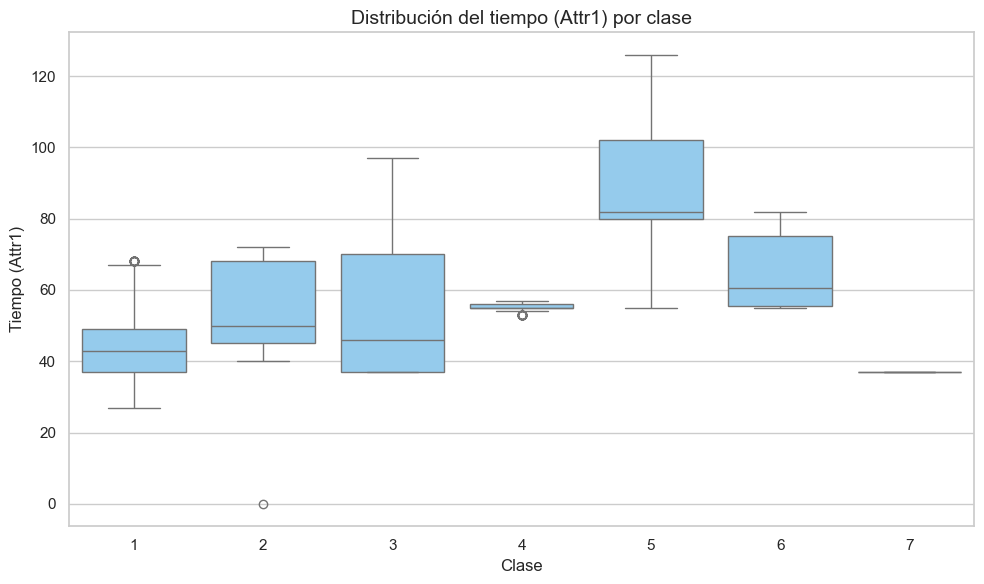

In [6]:
# Gráfico boxplot: tiempo por clase
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Class', y='Attr1', color='#87CEFA')
plt.title('Distribución del tiempo (Attr1) por clase', fontsize=14)
plt.xlabel('Clase')
plt.ylabel('Tiempo (Attr1)')
plt.tight_layout()
plt.show()


La gráfica de boxplot muestra que la variable de tiempo se distribuye de forma muy diferente entre clases, lo cual sugiere que el tiempo tiene un alto poder discriminativo.

Por ejemplo, la clase 4 está muy concentrada en torno al valor 55, mientras que la clase 5 abarca valores altos entre 55 y 130. También la clase 7 concentrada en valores específicos entorno al 38.


Esto indica que el tiempo puede ser una variable clave para distinguir clases, y sugiere que incluir Attr1 en el entrenamiento mejora significativamente la capacidad predictiva del modelo.

## Eliminamos Atributos Irrelevantes

In [7]:
# Filtrar solo las clases relevantes: 1, 4 y 5
clases_relevantes = [1, 4, 5]
train_df = train_df[train_df['Class'].isin(clases_relevantes)].copy()

# Verificar nueva distribución
from IPython.display import display, Markdown

clase_nueva = train_df['Class'].value_counts().sort_index()
display(Markdown("### Distribución de clases tras eliminar clases poco representadas"))
for clase, cantidad in clase_nueva.items():
    display(Markdown(f"- Clase `{clase}`: **{cantidad}** observaciones"))

# Gráfico de barras actualizado
plt.figure(figsize=(6, 4))
sns.barplot(x=clase_filtrada.index.astype(str), y=clase_filtrada.values, color='steelblue')
plt.title('Distribución de observaciones por clase (filtradas)', fontsize=14)
plt.xlabel('Clase')
plt.ylabel('Número de observaciones')
# Añadir los valores encima de cada barra
for i, count in enumerate(clase_filtrada.values):
    plt.text(i, count + max(clase_filtrada.values)*0.01, f'{count}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### Distribución de clases tras eliminar clases poco representadas

- Clase `1`: **34108** observaciones

- Clase `4`: **6748** observaciones

- Clase `5`: **2458** observaciones

NameError: name 'clase_filtrada' is not defined

<Figure size 600x400 with 0 Axes>

## Balancear las clases con el número de observaciones de la clase minoritaria

- Clase `1` : **2458** observaciones

- Clase `4` : **2458** observaciones

- Clase `5` : **2458** observaciones

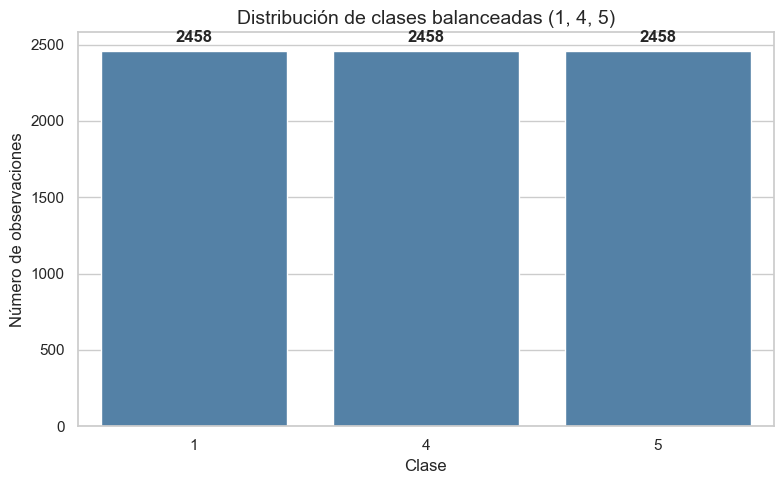

In [8]:
# Balancear a 2458 observaciones por clase (igualando a la clase 5)
n_target = 2458

# Filtrar clases
clases_filtradas = train_df[train_df['Class'].isin([1, 4, 5])]

# Balancear por muestreo aleatorio
clase_1 = clases_filtradas[clases_filtradas['Class'] == 1].sample(n=n_target, random_state=42)
clase_4 = clases_filtradas[clases_filtradas['Class'] == 4].sample(n=n_target, random_state=42)
clase_5 = clases_filtradas[clases_filtradas['Class'] == 5]

# Concatenar el nuevo dataframe balanceado
df_balanceado = pd.concat([clase_1, clase_4, clase_5])

# Comprobar distribución
conteo_balanceado = df_balanceado['Class'].value_counts().sort_index()
for clase, count in conteo_balanceado.items():
    display(Markdown(f"- Clase `{clase}` : **{count}** observaciones"))

# Visualización
plt.figure(figsize=(8, 5))
sns.barplot(x=conteo_balanceado.index.astype(str), y=conteo_balanceado.values, color='#4682B4')
plt.title('Distribución de clases balanceadas (1, 4, 5)', fontsize=14)
plt.xlabel('Clase')
plt.ylabel('Número de observaciones')
for i, count in enumerate(conteo_balanceado.values):
    plt.text(i, count + 40, f'{count}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


En lugar de aplicar técnicas sintéticas como RandomOverSampler o SMOTE, se optó por una estrategia directa y controlada para balancear el conjunto de datos.

Primero, se seleccionaron únicamente las clases 1, 4 y 5, por ser las únicas con un volumen de observaciones suficientemente representativo. Las demás clases fueron eliminadas por su baja frecuencia.

Después, se realizó un muestreo aleatorio de las clases 1 y 4 para reducir su tamaño a 2458 observaciones, igualando así a la clase minoritaria (clase 5). Este enfoque permite trabajar con un conjunto balanceado y representativo, sin introducir datos artificiales.

Gracias a este balanceo manual, se garantiza que cada clase tenga el mismo peso durante el entrenamiento del modelo, evitando así sesgos hacia la clase dominante.

## Verificación de Valores Nulos

In [9]:
# Contar valores nulos por columna
null_counts = train_df.isnull().sum()
nulls_presentes = null_counts[null_counts > 0]

if not nulls_presentes.empty:
    display(Markdown("**Se detectaron valores nulos en las siguientes columnas:**"))
    display(nulls_presentes.to_frame(name='Cantidad de nulos'))

    # Imputar con la media
    train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
    display(Markdown("**Los valores nulos han sido imputados con la media de cada columna.**"))
else:
    display(Markdown("**No se detectaron valores nulos en el conjunto de entrenamiento.**"))


**No se detectaron valores nulos en el conjunto de entrenamiento.**

## Verificación del Tipo de Dato Numérico

In [10]:
# Comprobar tipos de datos
tipos = df_balanceado.dtypes
display(tipos)
# Verificación automática
if all(tipos.apply(lambda x: np.issubdtype(x, np.number))):
    display(Markdown("Todos los atributos son numéricos."))



Attr1    int64
Attr2    int64
Attr3    int64
Attr4    int64
Attr5    int64
Attr6    int64
Attr7    int64
Attr8    int64
Attr9    int64
Class    int64
dtype: object

Todos los atributos son numéricos.

## Valores Atípicos (Outliers)

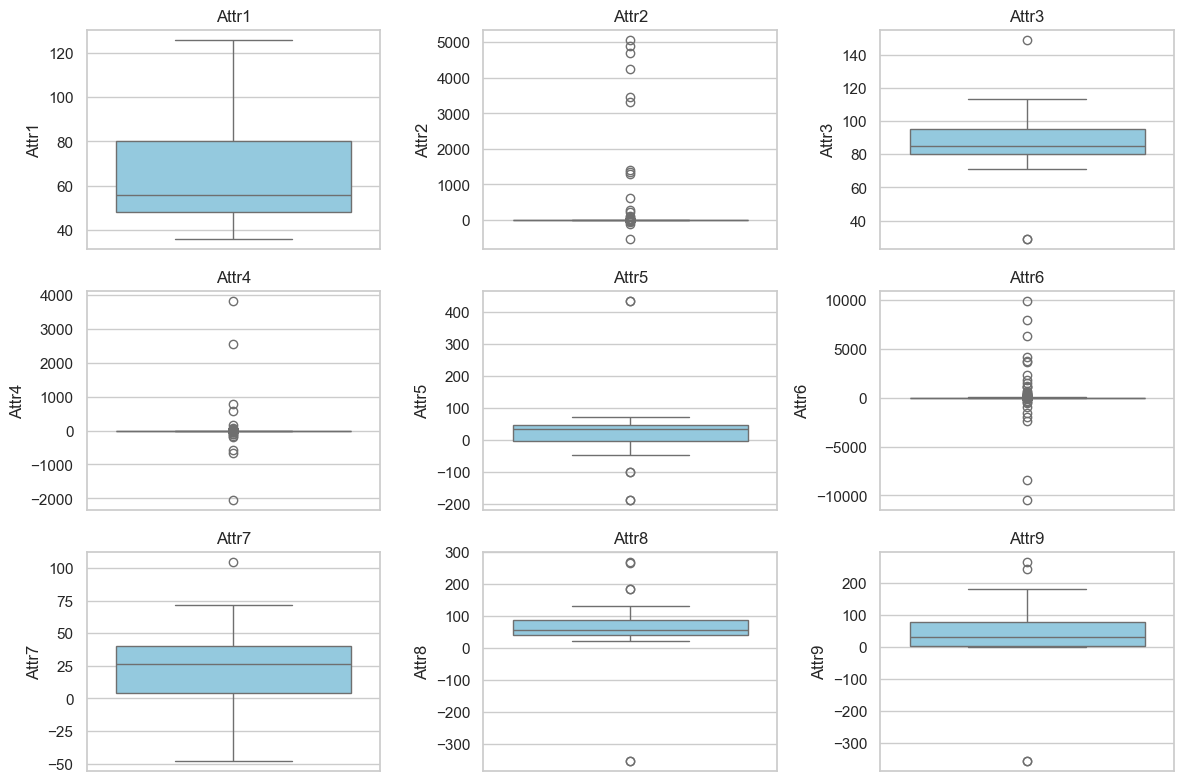

**Boxplots generados para todos los atributos. Se evalúa visualmente si hay outliers extremos.**

In [11]:
# Boxplots para ver outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate([f'Attr{i}' for i in range(1, 10)]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df_balanceado[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()


display(Markdown("**Boxplots generados para todos los atributos. Se evalúa visualmente si hay outliers extremos.**"))


Los boxplots muestran que varios atributos presentan valores atípicos (outliers), especialmente `Attr2`, `Attr4` y `Attr6`, que tienen una dispersión muy alta. Esto indica que hay datos extremos que podrían afectar el rendimiento del modelo si no se escalan correctamente.

## Normalización/Escalado mediante Z-score

In [13]:
from sklearn.preprocessing import StandardScaler

# Separar X e y
X = df_balanceado.drop('Class', axis=1)
y = df_balanceado['Class']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
train_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
train_scaled_df['Class'] = y.values

## Codificación de la Variable Clase

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_scaled_df['Class'] = label_encoder.fit_transform(train_scaled_df['Class'])

# Comprobar mapeo
display(Markdown(f"**Clases codificadas:** {list(label_encoder.classes_)}"))

# Mostrar mapeo original → codificado
mapping = {original: codificado for codificado, original in enumerate(label_encoder.classes_)}
display(Markdown(" **Codificación realizada.**"))
for original, codificado in mapping.items():
    display(Markdown(f"- Clase original `{original}` → codificada como `{codificado}`"))


**Clases codificadas:** [1, 4, 5]

 **Codificación realizada.**

- Clase original `1` → codificada como `0`

- Clase original `4` → codificada como `1`

- Clase original `5` → codificada como `2`

## Guardar CSV preprocesado y balanceado

In [15]:
# Guardar el dataframe balanceado en CSV
df_balanceado.to_csv('shuttle_train_balanceado_manual.csv', index=False)
print('Archivo guardado como shuttle_train_balanceado_manual.csv')

Archivo guardado como shuttle_train_balanceado_manual.csv


## Cargar y Preparar los datos

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Cargar el dataset
df_balanceado = pd.read_csv('shuttle_train_balanceado_manual.csv')

# Selección de variables
atributos = ['Attr1', 'Attr4', 'Attr5']
X = df_balanceado[atributos]
y = df_balanceado['Class']

# Escalado de los atributos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificación de la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)


## Validación Cruzada MLPClassifier

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
import numpy as np

# Crear validación cruzada estratificada con 5 particiones
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir el modelo MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

# Ejecutar la validación cruzada
mlp_scores = cross_val_score(mlp, X_scaled, y_encoded, cv=cv, scoring='accuracy')

# Mostrar resultados
print(f'Accuracy promedio: {np.mean(mlp_scores)*100:.2f}% ')


Accuracy promedio: 99.97% 


Se utiliza para evaluar el rendimiento del modelo antes del entrenamiento final, asegurando que generaliza bien a través de distintos subconjuntos del conjunto de datos.
Esto no entrena el modelo final, solo lo evalúa usando varios "mini-entrenamientos" internos.

## Entrenar el modelo MLP

In [18]:
# Entrenar el modelo MLP con todos los datos balanceados
mlp_final = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_final.fit(X_scaled, y_encoded) 

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

Una vez verificado que el modelo tiene un rendimiento satisfactorio con la validación cruzada, se entrena con todos los datos balanceados y preprocesados.
Este es el modelo que se usará después para hacer predicciones sobre shuttle.tst

### MLPClassifier (Multilayer Perceptron)
Es una red neuronal de tipo feedforward perteneciente a los métodos de aprendizaje profundo (deep learning). Se entrena utilizando el algoritmo de retropropagación del error (backpropagation) y un optimizador basado en gradiente.

- Está compuesta por una capa de entrada, una o más capas ocultas, y una capa de salida.

- Cada neurona realiza una combinación lineal de las entradas seguida de una función de activación no lineal (por ejemplo ReLU).

- Se ajustan los pesos sinápticos para minimizar una función de pérdida, habitualmente mediante descenso de gradiente estocástico.

## Evaluación Y Visualización Final


Accuracy del modelo MLP en shuttle.tst: 99.99%
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999     11478
           1     0.9991    1.0000    0.9995      2155
           2     1.0000    1.0000    1.0000       809

    accuracy                         0.9999     14442
   macro avg     0.9997    0.9999    0.9998     14442
weighted avg     0.9999    0.9999    0.9999     14442



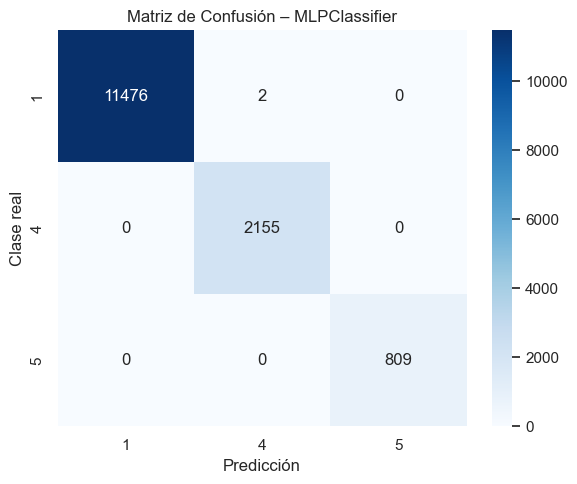

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar shuttle.test para las clases que utilizamos (1, 4 y 5)
test_df_filtrado = test_df[test_df['Class'].isin([1, 4, 5])].copy()

# Seleccionar únicamente las columnas relevantes
X_test_real = test_df_filtrado[['Attr1', 'Attr4', 'Attr5']]
y_test_real = test_df_filtrado['Class']

# Escalar atributos del test con el mismo scaler del entrenamiento
X_test_scaled = scaler.transform(X_test_real)

# Codificar etiquetas reales con el mismo LabelEncoder usado antes
y_test_encoded = le.transform(y_test_real)

# Hacer predicción con el modelo final
y_pred_mlp = mlp_final.predict(X_test_scaled)

# Evaluación de rendimiento
acc_mlp = accuracy_score(y_test_encoded, y_pred_mlp)
print(f'\nAccuracy del modelo MLP en shuttle.tst: {acc_mlp*100:.2f}%')
print(classification_report(y_test_encoded, y_pred_mlp, digits=4))

# Matriz de confusión
cm_mlp = confusion_matrix(y_test_encoded, y_pred_mlp)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión – MLPClassifier')
plt.xlabel('Predicción')
plt.ylabel('Clase real')
plt.tight_layout()
plt.show()


## Conclusión Final

Tras realizar un exhaustivo preprocesamiento, filtrado, balanceo y entrenamiento utilizando únicamente los atributos más relevantes (Attr1, Attr4 y Attr5), se entrenó un modelo MLPClassifier con validación cruzada y evaluación final en el conjunto independiente shuttle.tst.

Los resultados obtenidos demuestran el siguiente rendimiento:

Accuracy total: 99,99 %

Precisión, recall y F1-score por clase: todos mayores al 99,9 %

Matriz de confusión: muestra una clasificación casi perfecta, con solo 2 errores en más de 14.400 observaciones.

Macro avg: 99,98 % — el modelo mantiene un rendimiento equilibrado incluso entre clases menos frecuentes.

### Interpretación:

Este rendimiento indica que la selección cuidadosa de variables y un balanceo manual inteligente (reduciendo las clases 1 y 4 al nivel de la clase 5) fue altamente efectiva. El modelo MLP ha aprendido correctamente a distinguir entre las clases con los atributos seleccionados, sin sobreajustarse ni verse afectado por desbalanceo.

